Patterns based on all time, compare each point with previous.

In [18]:
#Import functions
import polars as pl
from functools import partial
from itertools import product
import multiprocessing
from numba import jit, typed #May have to be used later when reflected lists are deprecated, but does not work with partial
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import math
from dateutil.relativedelta import relativedelta

In [19]:
#Load dataframe from CSV
ticker = "NVDA"
current_df=pl.read_csv(f"../Data/SP500/minuteHist2021/tradingHours/{ticker}.csv", infer_schema_length=None)

In [20]:
#Get prices and timestamps from dataframe
open_prices=current_df['open'].to_numpy()
close_prices=current_df['close'].to_numpy()
timestamps=current_df['time'].to_numpy()

In [21]:
#Join data into one 2d array
data_array = np.dstack((open_prices, close_prices, timestamps))[0]
len(data_array)

259878

In [22]:
#Algo, new and improved
@jit(nopython=True, nogil=True)
def betterAlgo(length_and_gap, timeouts, fee, data_array):
    length = length_and_gap[0]
    gap = length_and_gap[1]
    start = 0
    end = int(len(data_array)-60)

    num_of_timeouts = len(timeouts)

    # [pattern, gap, timeout, number of trades, return]
    search_patterns=[]
    patterns=[]

    current_pattern=0
    
    for j in range(start, end):

        #Check that its not within the first or last hour of trading
        if 0<data_array[j][2]-data_array[j-60][2]<4500000 and 0<data_array[j+60][2]-data_array[j][2]<4500000:

        #Check that its all within one day of trading
        #if 0<data_array[j][2]-data_array[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<data_array[j+timeout][2]-data_array[j][2]<(60000*timeout*1.25):

        #Check that its all within first or last hour of trading
        #if 4500000<data_array[j][2]-data_array[j-60][2] or 4500000<data_array[j+60][2]-data_array[j][2]:

            current_pattern=0
            k=0
            while k<length:
                if data_array[j-(k*gap)][0]>data_array[j-((k+1)*gap)][0]:
                    current_pattern+=3*(10**k)
                else:
                    current_pattern+=1*(10**k)
                k+=1
            found = False
            for k in range(len(search_patterns)):
                if search_patterns[k][0] == current_pattern:
                    if search_patterns[k][1] == gap:
                        found = True

                        for t in range(len(timeouts)):
                            return_value = (data_array[j+timeouts[t]][0] - fee) / data_array[j][0]
                            patterns[k*num_of_timeouts+t][0] = (patterns[k*num_of_timeouts+t][0] * patterns[k*num_of_timeouts+t][2] + return_value) / (patterns[k*num_of_timeouts+t][2] + 1)
                            patterns[k*num_of_timeouts+t][1]*=return_value
                            patterns[k*num_of_timeouts+t][2]+=1
                        break
                        
            if not found:
                search_patterns.append([current_pattern, gap])
                for k in range(len(timeouts)):
                    return_value = (data_array[j+timeouts[k]][0] - fee) / data_array[j][0]
                    patterns.append([return_value, return_value, 1, timeouts[k], gap, current_pattern])

    return patterns

In [39]:
#Compile algo
patterns = betterAlgo([3,1], [50], 0.005, data_array)

In [25]:
#Run the algo over the full combinations list with multiprocessing
partialAlgo = partial(betterAlgo, timeouts=[1,2,3,5,10,20,30,50], fee=0.005, data_array=data_array)

lengths = [3,4,5,6,7,8,9,10,11]
gaps = [1,2,3,5]

lengths_gaps = product(lengths, gaps)

#List of results to store in right order
all_results=[]

#Start multiprocessing
with multiprocessing.Pool(8) as pool:
    result = pool.map(
        partialAlgo,
        lengths_gaps
    )
for mid in result:
    for pattern in mid:
        all_results.append(pattern)

In [26]:
def getSortedResults(current_results, minimum, maximum, n): #Function to sort the results
    results=[]

    for result in current_results:
        if maximum>=result[3]>=minimum:
            results.append(result)

    sorted_results = sorted(results.copy(), reverse=True)
    sorted_total_results = sorted(results.copy(), reverse=True, key=lambda x: x[1])
    results_df=pl.DataFrame(sorted_results, schema=["Return", "Total return", "Frequency", "Timeout", "Gap", "Pattern"])
    results_dfTotal=pl.DataFrame(sorted_total_results, schema=["Return", "Total return", "Frequency", "Timeout", "Gap", "Pattern"])
    return results_df, results_dfTotal

In [27]:
sorted_results, sorted_total_results=getSortedResults(all_results, 0, 10000, 5)
sorted_results[:5], sorted_total_results[:5]

(shape: (5, 6)
 ┌──────────┬──────────────┬───────────┬─────────┬─────┬───────────┐
 │ Return   ┆ Total return ┆ Frequency ┆ Timeout ┆ Gap ┆ Pattern   │
 │ ---      ┆ ---          ┆ ---       ┆ ---     ┆ --- ┆ ---       │
 │ f64      ┆ f64          ┆ f64       ┆ f64     ┆ f64 ┆ f64       │
 ╞══════════╪══════════════╪═══════════╪═════════╪═════╪═══════════╡
 │ 1.003156 ┆ 1.296861     ┆ 83.0      ┆ 50.0    ┆ 5.0 ┆ 1.3331e10 │
 │ 1.003045 ┆ 1.279723     ┆ 82.0      ┆ 50.0    ┆ 1.0 ┆ 1.3313e10 │
 │ 1.003044 ┆ 1.306663     ┆ 89.0      ┆ 50.0    ┆ 5.0 ┆ 3.3331e10 │
 │ 1.003032 ┆ 1.372944     ┆ 106.0     ┆ 50.0    ┆ 5.0 ┆ 3.3313e10 │
 │ 1.002974 ┆ 1.247478     ┆ 75.0      ┆ 50.0    ┆ 3.0 ┆ 1.1131e10 │
 └──────────┴──────────────┴───────────┴─────────┴─────┴───────────┘,
 shape: (5, 6)
 ┌──────────┬──────────────┬───────────┬─────────┬─────┬─────────┐
 │ Return   ┆ Total return ┆ Frequency ┆ Timeout ┆ Gap ┆ Pattern │
 │ ---      ┆ ---          ┆ ---       ┆ ---     ┆ --- ┆ ---     │
 │ f64   

In [85]:
#TestAlgo
#Numba for speed
@jit(nopython=True, nogil=True)
def testAlgo(params, data_array):
    fee = params[0]
    timeout = int(params[1])
    gap = int(params[2])
    pattern = str(int(params[3]))
    
    #params has an array of arrays with ticks before, change, version
    
    trade_percent=0
    total_return=1

    total=0

    start=60 #Start of data
    j=start
    end=int(len(data_array)-61) #End of data
    
    while j<end:
        #Check that its not within the first or last hour of trading
        if 0<data_array[j][2]-data_array[j-60][2]<4500000 and 0<data_array[j+60][2]-data_array[j][2]<4500000:

        #Check that its all within one day of trading
        #if 0<data_array[j][2]-data_array[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<data_array[j+timeout][2]-data_array[j][2]<(60000*timeout*1.25):

        #Check that its all within first or last hour of trading
        #if 4500000<data_array[j][2]-data_array[j-60][2] or 4500000<data_array[j+60][2]-data_array[j][2]:
            #Set start price and continue
            continue_params=True

            for k in range(len(pattern)):
                #Set price we are checking
                price_after=data_array[j-(gap*(k))][0]
                price_before=data_array[j-(gap*(k+1))][0]

                #If price now is above price we are checking, then continue, 3 means a price increase
                if pattern[-(k+1)]=="3":
                    if price_after<=price_before:
                        continue_params = False
                        break
                else:
                    if price_after>price_before:
                        continue_params = False
                        break

                # if price_after*change<price_before*change:
                #     continue_params = False
                #     break

            if continue_params:

                #Add to tally
                total+=1

                #Return on investment = new price / old price
                return_value = (data_array[j+timeout][0]-fee)/data_array[j][0]
                total_return*=return_value
                trade_percent+=return_value
                j+=timeout

        j+=1
        
    if total>0:
        trade_percent=trade_percent/total
        
    #Return the average trade percent, the total number of times, timeout, gap, and the parameters
    return_list = [trade_percent, total_return, total, timeout, gap, params[3]]
    return return_list
    # print(trade_percent)
    # print(tradePerDay)

#algo with all the dataframes already passed through
partialAlgo = partial(testAlgo, data_array=data_array)

In [87]:
testAlgo([0.005, 50.0, 5.0, 111.0], data_array)

[1.000350449951816, 2.2631315087314574, 2557.0, 50.0, 5.0, 111.0]

In [60]:
file_path = f"../Results/sp500/V4/{ticker}-minute2021-midday-33kParams-incFees.pkl" #Save file to pickle

# Save the all_results variable using pickle
with open(file_path, "wb") as file:
    pickle.dump(all_results, file)

In [61]:
def getSortedResults(current_results, minimum, maximum, n): #Function to sort the results
    results=[]

    for result in current_results:
        if maximum>=result[2]>=minimum:
            results.append(result)

    sorted_results = sorted(results.copy(), reverse=True)
    sorted_total_results = sorted(results.copy(), reverse=True, key=lambda x: x[1])
    results_df=pl.DataFrame(sorted_results[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sorted_results[0])-4)])
    results_dfTotal=pl.DataFrame(sorted_total_results[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sorted_results[0])-4)])
    return results_df, results_dfTotal

In [33]:
#Get all day
allday = False
if allday:
    file_path1 = f"../Results/sp500/V4/{ticker}-minute2021-allday-33kParams-incFees.pkl"

    with open(file_path1, 'rb') as file:
        all_results1 = pickle.load(file)

    sorted_results1, sorted_total_results1=getSortedResults(all_results1, 100, 100000, 500)
    sorted_total_results1[:5]

In [62]:
#Get mid day
midday = True
if midday:
    file_path2 = f"../Results/sp500/V4/{ticker}-minute2021-midday-33kParams-incFees.pkl"
    # Load data from pickle file
    with open(file_path2, 'rb') as file:
        all_results2 = pickle.load(file)

    sorted_results2, sorted_total_results2=getSortedResults(all_results2, 100, 100000, 500)
    sorted_total_results2[:5]

In [35]:
#Get out day
outday = False
if outday:
    file_path3 = f"../Results/sp500/V4/{ticker}-minute2021-outday-33kParams-incFees.pkl"
    # Load data from pickle file
    with open(file_path3, 'rb') as file:
        all_results3 = pickle.load(file)

    sorted_results3, sorted_total_results3=getSortedResults(all_results3, 100, 100000, 500)
    sorted_total_results3[:5]

In [63]:
#Split into time segments

start_unix = 1615780800000
end_unix = 1699070340000
months = (datetime.datetime.fromtimestamp(end_unix / 1000).year - datetime.datetime.fromtimestamp(start_unix / 1000).year) * 12 + (datetime.datetime.fromtimestamp(end_unix / 1000).month - datetime.datetime.fromtimestamp(start_unix / 1000).month) + 1


#Split into 2 week segments
week_dfs2 = []
for k in range(start_unix, end_unix, 1209600000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+1209600000)
    week_dfs2.append(temp_df)
len(week_dfs2)

#Convert 2 week dataframes to numpy arrays
week2_data_array=[]
for k in range(len(week_dfs2)):
    week2_data_array.append(np.dstack((week_dfs2[k]['open'].to_numpy(), week_dfs2[k]['close'].to_numpy(), week_dfs2[k]['time'].to_numpy()))[0])
len(week2_data_array)


#Split into 1 week segments
week_dfs1 = []
for k in range(start_unix, end_unix, 604800000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+604800000)
    week_dfs1.append(temp_df)
len(week_dfs1)

#Convert 1 week dataframes to numpy arrays
week_data_array=[]
for k in range(len(week_dfs1)):
    week_data_array.append(np.dstack((week_dfs1[k]['open'].to_numpy(), week_dfs1[k]['close'].to_numpy(), week_dfs1[k]['time'].to_numpy()))[0])
len(week_data_array)


#Split into 1 day segments
day_dfs = []
for k in range(start_unix, end_unix, 86400000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+86400000)
    if len(temp_df)>0:
        day_dfs.append(temp_df)
len(day_dfs)

#Convert day dataframes to numpy arrays
day_data_array=[]
for k in range(len(day_dfs)):
    day_data_array.append(np.dstack((day_dfs[k]['open'].to_numpy(), day_dfs[k]['close'].to_numpy(), day_dfs[k]['time'].to_numpy()))[0])
len(day_data_array)


#Split into 1 month segments
month_dfs = []
current_month = datetime.datetime.fromtimestamp(day_dfs[0][0]['time'][0] / 1000).month
temp_df = day_dfs[0]
for k in range(len(day_dfs)):
    if current_month == datetime.datetime.fromtimestamp(day_dfs[k][0]['time'][0] / 1000).month:
        temp_df.extend(day_dfs[k])
    else:
        month_dfs.append(temp_df)
        current_month = datetime.datetime.fromtimestamp(day_dfs[k][0]['time'][0] / 1000).month
        temp_df = day_dfs[k]

#Convert month dataframes to numpy arrays
month_data_array=[]
for k in range(len(month_dfs)):
    month_data_array.append(np.dstack((month_dfs[k]['open'].to_numpy(), month_dfs[k]['close'].to_numpy(), month_dfs[k]['time'].to_numpy()))[0])
len(month_data_array)

#Split into 1 day segments
day_dfs = []
for k in range(start_unix, end_unix, 86400000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+86400000)
    day_dfs.append(temp_df)
len(day_dfs)

#Convert day dataframes to numpy arrays
day_data_array=[]
for k in range(len(day_dfs)):
    day_data_array.append(np.dstack((day_dfs[k]['open'].to_numpy(), day_dfs[k]['close'].to_numpy(), day_dfs[k]['time'].to_numpy()))[0])
len(day_data_array)

964

In [64]:
testAlgo(np.array([0.005] + list(sorted_total_results2[0,3:].rows()[0])), data_array)[1]

1262.9561751323

Correlation Coefficient: 0.7546966684578472


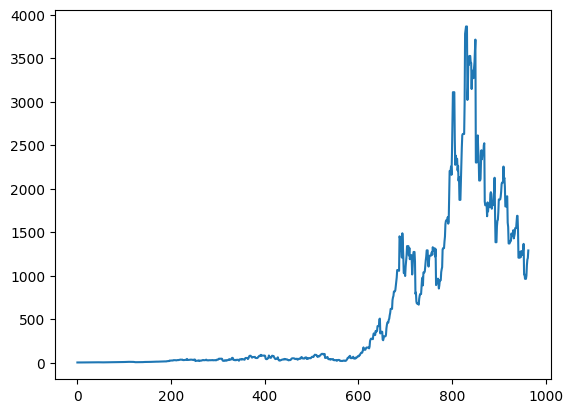

In [68]:
#Graph of PnL over time and print correlation
return_over_time=[1]
for k in range(1, len(day_dfs)):
    return_over_time.append(return_over_time[-1]*testAlgo(np.array([0.005] + list(sorted_total_results2[0,3:].rows()[0])), day_data_array[k])[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
x = np.array(range(len(return_over_time)))
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

In [70]:
#Functions for graph of PnL for each period with anomolies

def sharpeRatio(returns, increment):
    match increment:
        case "day":
            periods = 252
        case "week":
            periods = 52
        case "month":
            periods = 12
    risk_free_rate = (1.06**(1/periods)) - 1
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * math.sqrt(periods)
    return sharpe_ratio

def sortinoRatio(returns, increment):
    match increment:
        case "day":
            periods = 252
        case "week":
            periods = 52
        case "month":
            periods = 12
    risk_free_rate = (1.06**(1/periods)) - 1
    np_returns = np.array(returns)
    downside_returns = np.where(np_returns < risk_free_rate, np_returns - risk_free_rate, 0)
    downside_deviation = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) - risk_free_rate) / downside_deviation * math.sqrt(periods)
    return sortino_ratio

def plot(increment, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):

    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = testAlgo(np.array([0.005]+list(sorted_total_results2[0,3:].rows()[0])), used_data_array[k])[1]-1
            return_per_day.append(result)
            dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    plt.grid()

    mean_return = np.mean(return_per_day)
    std_deviation = np.std(return_per_day)
    risk_free_rate = (1.06**(1/252)) - 1
    print("Annualized sharpe Ratio:", sharpeRatio(return_per_day, increment))
    print("Annualized sortino Ratio:", sortinoRatio(return_per_day, increment))

def plotAnomalies(increment, resultThreshold=-math.inf, print_true = False, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):
    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    over_threshold = []
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = testAlgo(np.array([0.005, 1]+list(sorted_total_results2[0,3:].rows()[0])), used_data_array[k])[1]-1
            if result > resultThreshold or result < -resultThreshold:
                over_threshold.append((datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000), result))
                return_per_day.append(result)
                dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    if print_true:
        for k in range(len(over_threshold)):
            print(over_threshold[k][0].date(), over_threshold[k][1])

Annualized sharpe Ratio: 2.205647567045224
Annualized sortino Ratio: 5.127756061343907


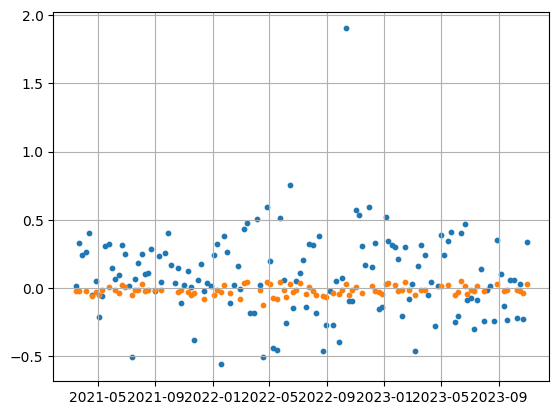

In [71]:
#Start date is 2021-03-15, end date is 2023-11-03
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 11, 3)
increment = "week"
anomaly = 0.01
plot(increment)
plotAnomalies(increment, anomaly, print_true=False)

In [113]:
#MultiAlgo
#Numba for speed
@jit(nopython=True, nogil=True)
def multiAlgo(concurrent, params_list, data_array):
    fee=params_list[0] #Percent change in price to look for
    all_params=params_list[1:]
    params = []
    for k in range(concurrent):
        params.append(all_params[k*len(all_params)//concurrent:(k+1)*len(all_params)//concurrent])
    
    #params has an array of arrays with ticks before, change, version
    
    trade_percent=0
    total_return=1

    total=0

    start=0 #Start of data
    j=start
    end=int(len(data_array)-61) #End of data
    
    while j < end:
        #Check that its not within the first or last hour of trading
        if 0<data_array[int(j)][2]-data_array[int(j-60)][2]<4500000 and 0<data_array[int(j+60)][2]-data_array[int(j)][2]<4500000:

        #Check that its all within one day of trading
        #if 0<data_array[j][2]-data_array[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<data_array[j+timeout][2]-data_array[j][2]<(60000*timeout*1.25):

        #Check that its all within first or last hour of trading
        #if 4500000<data_array[j][2]-data_array[j-60][2] or 4500000<data_array[j+60][2]-data_array[j][2]:

            h=0
            while h < concurrent:
                timeout = params[h][0]
                gap = params[h][1]
                pattern = str(int(params[h][2]))

                continue_params=True

                for k in range(len(pattern)):

                    #Set price we are checking
                    price_after=data_array[int(j-(gap*(k)))][0]
                    price_before=data_array[int(j-(gap*(k+1)))][0]

                    #If price now is above price we are checking, then continue, 1 means a price increase

                    if pattern[-(k+1)]=="3":
                        if price_after<=price_before:
                            continue_params = False
                            break
                    else:
                        if price_after>price_before:
                            continue_params = False
                            break

                if continue_params:
                    #Add to tally
                    h=concurrent
                    total+=1

                    #Return on investment = new price / old price
                    return_value = (data_array[int(j+timeout)][0]-fee)/data_array[int(j)][0]
                    total_return*=return_value
                    trade_percent+=return_value
                    j+=timeout
                h+=1
        j+=1
    
    if total>0:
        trade_percent=trade_percent/total
        
    #Return the average trade percent, the total number of times, timeout, gap, and the parameters
    return_list = [trade_percent, total_return, total]
    return return_list

In [116]:
#Choose how many concurrent algos to run
params_list = range(30)
params = [0.005]
for k in params_list:
    params += list(sorted_results2[k,3:].rows()[0])
concurrent = len(params)//len(sorted_results2[0,3:].rows()[0])


multiAlgo(concurrent, params, data_array)

[1.0015566438328505, 12.44490836488778, 1650.0]

Correlation Coefficient: 0.9607820892716646


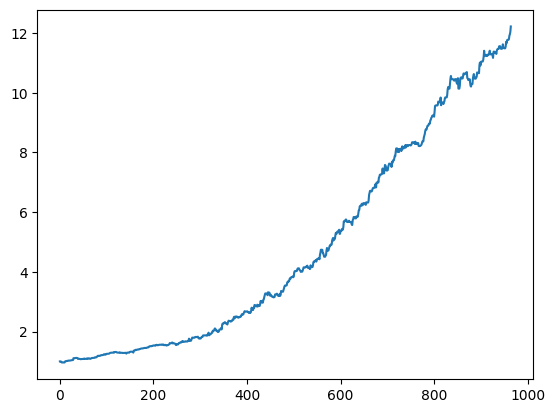

In [117]:
#Graph of PnL over time and print correlation
return_over_time=[1]
points = list(range(0,len(day_data_array)))
for k in points:
    start_time = datetime.time
    return_over_time.append(return_over_time[-1]*multiAlgo(concurrent, params, day_data_array[k])[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
points.append(len(day_data_array))
x = np.array(points)
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

In [118]:
#Functions for graph of PnL for each period with anomolies
def multiPlot(increment, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):

    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = multiAlgo(concurrent, params, used_data_array[k])[1]-1
            return_per_day.append(result)
            dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    plt.grid()

    print("Annualized sharpe Ratio:", sharpeRatio(return_per_day, increment))
    print("Annualized sortino Ratio:", sortinoRatio(return_per_day, increment))
    


def multiPlotAnomalies(increment, resultThreshold=-math.inf, print_true = False, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):
    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    over_threshold = []
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = multiAlgo(concurrent, params, used_data_array[k])[1]-1
            if result > resultThreshold or result < -resultThreshold:
                over_threshold.append((datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000), result))
                return_per_day.append(result)
                dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    if print_true:
        for k in range(len(over_threshold)):
            print(over_threshold[k][0].date(), over_threshold[k][1])

Annualized sharpe Ratio: 4.793923157596551
Annualized sortino Ratio: 10.36401029978288


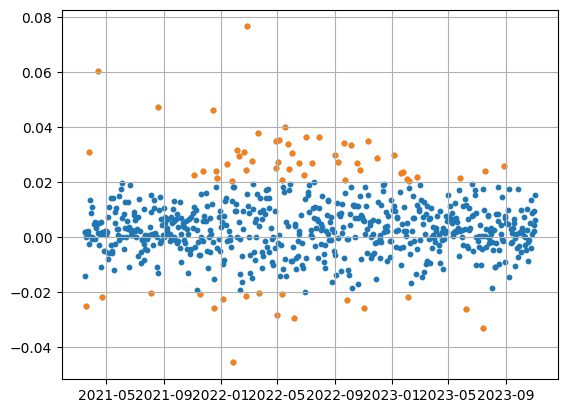

In [119]:
#Start date is 2021-03-15, end date is 2023-11-03
start_date = datetime.datetime(2021, 3, 15)
end_date = datetime.datetime(2023, 11, 3)
increment = "day"
anomaly = 0.02
multiPlot(increment)
multiPlotAnomalies(increment, anomaly, print_true=False)